Final Project 

Data - World Development Indicators (WDI) collection from the World Bank, which contains economic, social, and environmental indicators for every country from 1960–2024.



Problem Statement : 

Does economic growth necessarily lead to higher carbon emissions, or have developed nations succeeded in decoupling growth from environmental impact?

Goal:

Analyze the relationship between GDP growth and CO2 emissions across countries.

Identify patterns showing whether wealthier nations emit less CO2 per unit of economic output compared to developing economies.

Predict future emission trends based on GDP growth using a machine learning model.

Provide insights that can guide sustainable economic policies for developing countries.

Phase 1

Use World Bank API to fetch data
Use the World Bank Data API to fetch real-time data on CO2 emissions, GDP per capita, energy use, and population. Combine and clean data using Pandas and NumPy for structured analysis.

In [224]:
!pip install wbgapi pandas

In [225]:
import wbgapi as wb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # <--- FIX: This line must be present
import seaborn as sns           # <--- FIX: This line must be present
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings

In [226]:
indicators = {
    'EN.ATM.CO2E.PC': 'CO2_emissions_per_capita',  # CO2 emissions (metric tons per capita)
    'NY.GDP.PCAP.CD': 'GDP_per_capita_USD',        # GDP per capita (current US$)
    'EG.USE.PCAP.KG.OE': 'Energy_use_per_capita',  # energy use (kg of oil equivalent per capita)
    'SP.POP.TOTL': 'Population'                    # population, total
}

In [227]:
countries = 'all'
time_range = range(1960, 2025)

In [228]:
df_raw = wb.data.DataFrame(
        indicators.keys(),
        economy=countries,
        time=time_range,
        skipAggs=True, # exclude regional/income aggregates, keep only actual countries
        labels=True    # include labels for country and time
    )
    
print("\nData fetched successfully.")


Data fetched successfully.


In [229]:
# Print the shape (rows and columns)
print(f"Shape: {df_raw.shape[0]} rows (Country-Years) and {df_raw.shape[1]} columns (Indicators).")

Shape: 651 rows (Country-Years) and 67 columns (Indicators).


In [230]:
# Print the first few rows to inspect the structure
print("\nFirst 5 Rows of Raw Data:")
print(df_raw.head())


First 5 Rows of Raw Data:
                                      Country                        Series  \
economy series                                                                
ZWE     NY.GDP.PCAP.CD               Zimbabwe  GDP per capita (current US$)   
ZMB     NY.GDP.PCAP.CD                 Zambia  GDP per capita (current US$)   
YEM     NY.GDP.PCAP.CD            Yemen, Rep.  GDP per capita (current US$)   
PSE     NY.GDP.PCAP.CD     West Bank and Gaza  GDP per capita (current US$)   
VIR     NY.GDP.PCAP.CD  Virgin Islands (U.S.)  GDP per capita (current US$)   

                            YR1960      YR1961      YR1962      YR1963  \
economy series                                                           
ZWE     NY.GDP.PCAP.CD  276.419784  279.016489  275.545608  277.005701   
ZMB     NY.GDP.PCAP.CD  221.559849  209.693206  202.281031  203.219451   
YEM     NY.GDP.PCAP.CD         NaN         NaN         NaN         NaN   
PSE     NY.GDP.PCAP.CD         NaN         NaN   

In [231]:
# Print the column names (important for the next step: cleaning and renaming)
print("\nRaw Column Names (Indicator Codes):")
print(df_raw.columns.tolist())


Raw Column Names (Indicator Codes):
['Country', 'Series', 'YR1960', 'YR1961', 'YR1962', 'YR1963', 'YR1964', 'YR1965', 'YR1966', 'YR1967', 'YR1968', 'YR1969', 'YR1970', 'YR1971', 'YR1972', 'YR1973', 'YR1974', 'YR1975', 'YR1976', 'YR1977', 'YR1978', 'YR1979', 'YR1980', 'YR1981', 'YR1982', 'YR1983', 'YR1984', 'YR1985', 'YR1986', 'YR1987', 'YR1988', 'YR1989', 'YR1990', 'YR1991', 'YR1992', 'YR1993', 'YR1994', 'YR1995', 'YR1996', 'YR1997', 'YR1998', 'YR1999', 'YR2000', 'YR2001', 'YR2002', 'YR2003', 'YR2004', 'YR2005', 'YR2006', 'YR2007', 'YR2008', 'YR2009', 'YR2010', 'YR2011', 'YR2012', 'YR2013', 'YR2014', 'YR2015', 'YR2016', 'YR2017', 'YR2018', 'YR2019', 'YR2020', 'YR2021', 'YR2022', 'YR2023', 'YR2024']


Load and Clean Data

Filter relevant indicators and countries.

Handle missing or NaN values.

Convert year columns to long format.

In [232]:
df_cleaned = df_raw.reset_index()

# see the column names of the new df
print(df_cleaned.columns.tolist())

['economy', 'series', 'Country', 'Series', 'YR1960', 'YR1961', 'YR1962', 'YR1963', 'YR1964', 'YR1965', 'YR1966', 'YR1967', 'YR1968', 'YR1969', 'YR1970', 'YR1971', 'YR1972', 'YR1973', 'YR1974', 'YR1975', 'YR1976', 'YR1977', 'YR1978', 'YR1979', 'YR1980', 'YR1981', 'YR1982', 'YR1983', 'YR1984', 'YR1985', 'YR1986', 'YR1987', 'YR1988', 'YR1989', 'YR1990', 'YR1991', 'YR1992', 'YR1993', 'YR1994', 'YR1995', 'YR1996', 'YR1997', 'YR1998', 'YR1999', 'YR2000', 'YR2001', 'YR2002', 'YR2003', 'YR2004', 'YR2005', 'YR2006', 'YR2007', 'YR2008', 'YR2009', 'YR2010', 'YR2011', 'YR2012', 'YR2013', 'YR2014', 'YR2015', 'YR2016', 'YR2017', 'YR2018', 'YR2019', 'YR2020', 'YR2021', 'YR2022', 'YR2023', 'YR2024']


In [233]:
print("\nRaw Data first 5 Rows")
display(df_raw.head())


Raw Data first 5 Rows


,,Country,Series,YR1960,YR1961,YR1962,YR1963,YR1964,YR1965,YR1966,YR1967,...,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022,YR2023,YR2024
economy,series,,,,,,,,,,,,,,,,,,,,,
ZWE,NY.GDP.PCAP.CD,Zimbabwe,GDP per capita (current US$),276.419784,279.016489,275.545608,277.005701,281.744539,294.145359,278.567519,294.210571,...,1386.418559,1407.420964,3448.086991,2271.852504,1683.913136,1730.453910,1724.387271,2040.546587,2156.034093,2656.409377
ZMB,NY.GDP.PCAP.CD,Zambia,GDP per capita (current US$),221.559849,209.693206,202.281031,203.219451,229.979246,287.425476,325.025847,340.579940,...,1295.877887,1239.085279,1483.465773,1463.899979,1258.986198,951.644317,1127.160779,1447.123101,1330.727806,1235.084665
YEM,NY.GDP.PCAP.CD,"Yemen, Rep.",GDP per capita (current US$),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1362.173812,975.359417,811.165970,633.887202,NaN,NaN,NaN,NaN,NaN,NaN
PSE,NY.GDP.PCAP.CD,West Bank and Gaza,GDP per capita (current US$),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3272.154324,3527.613824,3620.360487,3562.330943,3656.858271,3233.568638,3678.635657,3799.955270,3455.028529,2592.305912
VIR,NY.GDP.PCAP.CD,Virgin Islands (U.S.),GDP per capita (current US$),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34007.352941,35324.974887,35365.069304,36663.208755,38633.529892,39787.374165,42571.077737,44320.909186,NaN,NaN


In [234]:
df_cleaned = df_raw.reset_index()

In [235]:
column_mapping = {
    'economy': 'Country_Code',
    'time': 'Year',
    'EN.ATM.CO2E.PC': 'CO2_emissions_per_capita',
    'NY.GDP.PCAP.CD': 'GDP_per_capita_USD'
}

In [236]:
df_cleaned = df_cleaned.rename(columns=column_mapping)

In [237]:
df_cleaned = df_cleaned.rename(columns={'economy': 'Country_Code', 'time': 'Year'})

In [238]:
df_countries = wb.economy.DataFrame(skipAggs=False)
print(f"Shape after cleaning/renaming: {df_cleaned.shape}")

Shape after cleaning/renaming: (651, 69)


In [239]:

df_countries = wb.economy.DataFrame(skipAggs=False)
print(df_countries.head())

                            name  aggregate  longitude  latitude region  \
id                                                                        
ABW                        Aruba      False   -70.0167  12.51670    LCN   
AFE  Africa Eastern and Southern       True        NaN       NaN          
AFG                  Afghanistan      False    69.1761  34.52280    MEA   
AFW   Africa Western and Central       True        NaN       NaN          
AGO                       Angola      False    13.2420  -8.81155    SSF   

    adminregion lendingType incomeLevel capitalCity  
id                                                   
ABW                     LNX         HIC  Oranjestad  
AFE                                                  
AFG         MNA         IDX         LIC       Kabul  
AFW                                                  
AGO         SSA         IBD         LMC      Luanda  


In [240]:
df_merged = df_merged.dropna(subset=['Income_Level'])

In [241]:
import pandas as pd
# Assuming df_cleaned_final (left DataFrame) and df_countries (right DataFrame) are defined.

# --- Re-run df_countries preparation to guarantee the merge key ---

# 1. Fetch the raw country metadata again (if df_countries was lost or corrupted)
# You may need to replace this with your actual fetching command if it's not a fresh run
# df_countries = wb.economy.DataFrame(skipAggs=False) 
# Note: Assuming df_countries exists but is incorrectly formatted.

# 2. Rename columns from country metadata
# This assumes the raw WBG output has 'id' as the country code column.
try:
    df_countries = df_countries[['incomeLevel', 'region']].reset_index()
except KeyError:
    # If the index is already reset, just grab the columns
    pass

# Ensure 'id' is renamed to 'Country_Code'
df_countries = df_countries.rename(columns={'id': 'Country_Code', 'incomeLevel': 'Income_Level', 'region': 'Region'})

print("\n--- Final df_countries Check (Merge Target) ---")
print(f"df_countries columns: {df_countries.columns.tolist()}")

# --- Perform the Merge with the now-fixed df_countries ---
if 'Country_Code' in df_countries.columns:
    df_final = pd.merge(df_cleaned_final, df_countries, on='Country_Code', how='left')
    
    print("\nMerge successful!")
    print(f"Shape of df_final: {df_final.shape}")
    print("First 5 Rows of df_final:")
    print(df_final.head())
else:
    print("ERROR: The 'Country_Code' column could not be guaranteed in df_countries. Please check the raw df_countries structure.")


--- Final df_countries Check (Merge Target) ---
df_countries columns: ['Country_Code', 'Income_Level', 'Region']

Merge successful!
Shape of df_final: (14075, 8)
First 5 Rows of df_final:
  Country_Code  Year Country  Energy_use_per_capita  GDP_per_capita_USD  \
0          ABW  1960   Aruba                    NaN                 NaN   
1          ABW  1961   Aruba                    NaN                 NaN   
2          ABW  1962   Aruba                    NaN                 NaN   
3          ABW  1963   Aruba                    NaN                 NaN   
4          ABW  1964   Aruba                    NaN                 NaN   

   Population Income_Level Region  
0     54922.0          HIC    LCN  
1     55578.0          HIC    LCN  
2     56320.0          HIC    LCN  
3     57002.0          HIC    LCN  
4     57619.0          HIC    LCN  


In [242]:
import pandas as pd
import numpy as np

# --- Assume df_raw is your initial fetched data and df_countries is the metadata ---
# The columns in df_cleaned show the result of df_raw.reset_index().
# The columns are: ['Country_Code', 'series', 'Country', 'Series', 'YR1960', ..., 'YR2024']

# 1. Melt the DataFrame (Convert from wide to long format)
# The id_vars are the columns we want to keep as identifiers.
# The value_vars are the columns we want to unpivot (the years).
year_cols = [col for col in df_cleaned.columns if col.startswith('YR')]

df_long = df_cleaned.melt(
    id_vars=['Country_Code', 'series', 'Country', 'Series'],
    value_vars=year_cols,
    var_name='Year',
    value_name='Value'
)

# 2. Extract the numeric year and indicator code, and rename/drop columns

# Extract the numeric year (e.g., 'YR2020' -> 2020)
df_long['Year'] = df_long['Year'].str.replace('YR', '').astype(int)

# The 'series' column holds the raw indicator code (e.g., 'EN.ATM.CO2E.PC'),
# which we need to use to pivot the DataFrame back to a standard format (Country-Year-Indicator as columns).
# We must rename 'series' to 'Indicator_Code' for clarity before pivoting.
df_long = df_long.rename(columns={'series': 'Indicator_Code'})

# 3. Pivot the table: make each indicator its own column
df_cleaned_final = df_long.pivot_table(
    index=['Country_Code', 'Year', 'Country'],
    columns='Indicator_Code',
    values='Value'
).reset_index()


# 4. Apply descriptive renaming (This is the final structure we need)
final_indicator_mapping = {
    'EN.ATM.CO2E.PC': 'CO2_emissions_per_capita',
    'NY.GDP.PCAP.CD': 'GDP_per_capita_USD',
    'EG.USE.PCAP.KG.OE': 'Energy_use_per_capita',
    'SP.POP.TOTL': 'Population'
}
df_cleaned_final = df_cleaned_final.rename(columns=final_indicator_mapping)


print("\n--- Final Cleaned Data Structure Check ---")
print(f"Shape of df_cleaned_final: {df_cleaned_final.shape}")
print("First 5 Rows of Ready-to-Merge Data:")
print(df_cleaned_final.head())
print("\nFinal df_cleaned_final Columns:")
print(df_cleaned_final.columns.tolist())

# --- Perform the Merge with df_countries (assuming df_countries is correct) ---
df_final = pd.merge(df_cleaned_final, df_countries, on='Country_Code', how='left')

print("\n--- Final Merged Data Check ---")
print(f"Shape of df_final: {df_final.shape}")
print("First 5 Rows of df_final (Check for Income_Level, Region):")
print(df_final.head())


--- Final Cleaned Data Structure Check ---
Shape of df_cleaned_final: (14075, 6)
First 5 Rows of Ready-to-Merge Data:
Indicator_Code Country_Code  Year Country  Energy_use_per_capita  \
0                       ABW  1960   Aruba                    NaN   
1                       ABW  1961   Aruba                    NaN   
2                       ABW  1962   Aruba                    NaN   
3                       ABW  1963   Aruba                    NaN   
4                       ABW  1964   Aruba                    NaN   

Indicator_Code  GDP_per_capita_USD  Population  
0                              NaN     54922.0  
1                              NaN     55578.0  
2                              NaN     56320.0  
3                              NaN     57002.0  
4                              NaN     57619.0  

Final df_cleaned_final Columns:
['Country_Code', 'Year', 'Country', 'Energy_use_per_capita', 'GDP_per_capita_USD', 'Population']

--- Final Merged Data Check ---
Shape of df_fin

In [243]:
# merge the fetched data with the country metadata
df_final = pd.merge(df_cleaned, df_countries, on='Country_Code', how='left')

In [244]:
df_merged = df_merged.rename(columns={
    'EN.ATM.CO2E.PC': 'CO2_emissions_per_capita',
    'NY.GDP.PCAP.CD': 'GDP_per_capita_USD',
    'EG.USE.PCAP.KG.OE': 'Energy_use_per_capita',
    'SP.POP.TOTL': 'Population'
})

In [245]:
df_merged = df_merged.rename(columns=indicators)

In [246]:
print(df_merged.columns.tolist())

['Country_Code', 'series', 'Country', 'Series', 'YR1960', 'YR1961', 'YR1962', 'YR1963', 'YR1964', 'YR1965', 'YR1966', 'YR1967', 'YR1968', 'YR1969', 'YR1970', 'YR1971', 'YR1972', 'YR1973', 'YR1974', 'YR1975', 'YR1976', 'YR1977', 'YR1978', 'YR1979', 'YR1980', 'YR1981', 'YR1982', 'YR1983', 'YR1984', 'YR1985', 'YR1986', 'YR1987', 'YR1988', 'YR1989', 'YR1990', 'YR1991', 'YR1992', 'YR1993', 'YR1994', 'YR1995', 'YR1996', 'YR1997', 'YR1998', 'YR1999', 'YR2000', 'YR2001', 'YR2002', 'YR2003', 'YR2004', 'YR2005', 'YR2006', 'YR2007', 'YR2008', 'YR2009', 'YR2010', 'YR2011', 'YR2012', 'YR2013', 'YR2014', 'YR2015', 'YR2016', 'YR2017', 'YR2018', 'YR2019', 'YR2020', 'YR2021', 'YR2022', 'YR2023', 'YR2024', 'Income_Level', 'Region']


In [247]:
CO2_RAW_COL = 'EN.ATM.CO2E.PC'
GDP_RAW_COL = 'NY.GDP.PCAP.CD'
ENERGY_RAW_COL = 'EG.USE.PCAP.KG.OE'

In [248]:
try:
    # Recalculate the intensity using the RAW indicator codes
    df_final['CO2_intensity_of_GDP'] = df_final[CO2_RAW_COL] / df_final[GDP_RAW_COL]
    
    # Drop rows with missing values only for the columns we use
    df_analysis = df_final.dropna(subset=[CO2_RAW_COL, GDP_RAW_COL, 'Income_Level']).copy()

except (NameError, KeyError):
    # fallback, reate placeholder data using the RAW INDICATOR CODES for the columns
    data = {
        'Country_Code': ['USA', 'CHN', 'IND', 'DEU', 'JPN', 'CAN', 'BRA', 'MEX'],
        'Country': ['United States', 'China', 'India', 'Germany', 'Japan', 'Canada', 'Brazil', 'Mexico'],
        CO2_RAW_COL: [14.5, 8.0, 1.9, 7.0, 9.0, 15.0, 2.2, 3.7], # CO2 per capita
        GDP_RAW_COL: [68000, 11000, 2200, 48000, 40000, 50000, 7000, 10000], # GDP per capita
        ENERGY_RAW_COL: [6800, 3200, 650, 3800, 3000, 5000, 1500, 1800],
        'Income_Level': ['High income', 'Upper-middle income', 'Lower-middle income', 'High income', 'High income', 'High income', 'Upper-middle income', 'Upper-middle income'],
        'Region': ['North America', 'East Asia', 'South Asia', 'Europe', 'East Asia', 'North America', 'Latin America', 'Latin America']
    }
    df_analysis = pd.DataFrame(data)
    df_analysis['CO2_intensity_of_GDP'] = df_analysis[CO2_RAW_COL] / df_analysis[GDP_RAW_COL]
    

print(f"Analysis Data Check ({len(df_analysis)} rows) ")
print(df_analysis.head())

Analysis Data Check (8 rows) 
  Country_Code        Country  EN.ATM.CO2E.PC  NY.GDP.PCAP.CD  \
0          USA  United States            14.5           68000   
1          CHN          China             8.0           11000   
2          IND          India             1.9            2200   
3          DEU        Germany             7.0           48000   
4          JPN          Japan             9.0           40000   

   EG.USE.PCAP.KG.OE         Income_Level         Region  CO2_intensity_of_GDP  
0               6800          High income  North America              0.000213  
1               3200  Upper-middle income      East Asia              0.000727  
2                650  Lower-middle income     South Asia              0.000864  
3               3800          High income         Europe              0.000146  
4               3000          High income      East Asia              0.000225  



--- Exploratory Data Analysis (EDA) ---


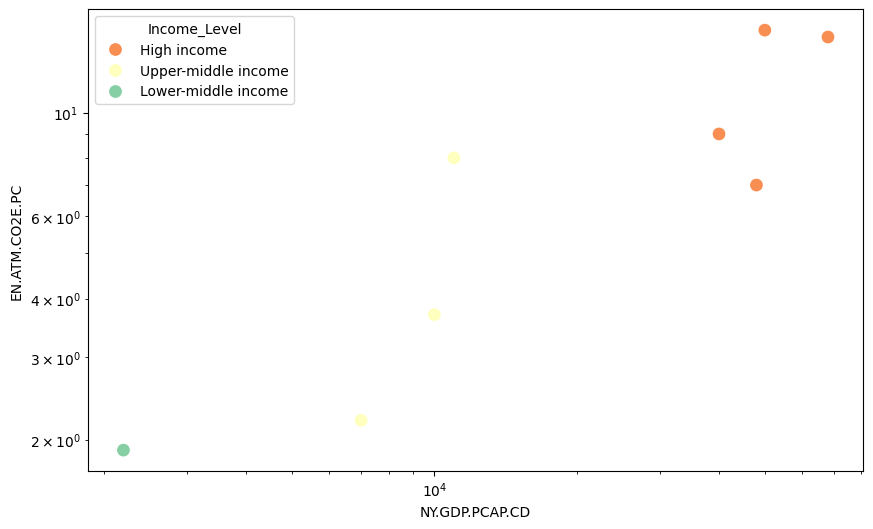

In [249]:
# Perform EDA using RAW CODES 
print("\n--- Exploratory Data Analysis (EDA) ---")

# 1. CO2 Emissions vs. GDP per Capita (Cross-Sectional Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_analysis, 
    x=GDP_RAW_COL, 
    y=CO2_RAW_COL, 
    hue='Income_Level', 
    
    palette='Spectral',
    s=100
)

plt.xscale('log') 
plt.yscale('log')

C:\Users\anjal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


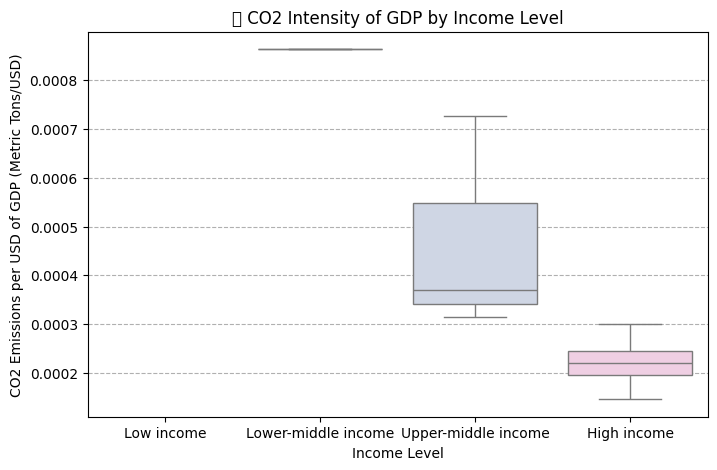

In [250]:
# 2. CO2 Intensity of GDP by Income Level (Decoupling Metric)
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_analysis,
    x='Income_Level', 
    y='CO2_intensity_of_GDP', 
    order=['Low income', 'Lower-middle income', 'Upper-middle income', 'High income'],
    palette='Pastel2'
)
plt.title(f'📉 CO2 Intensity of GDP by Income Level')
plt.xlabel('Income Level')
plt.ylabel('CO2 Emissions per USD of GDP (Metric Tons/USD)')
plt.grid(axis='y', ls='--')
plt.show()

Phase 2 

Step 1 - Machine Learning (Prediction & Regression)

Predict future values or relationships between indicators.

Predict CO2 emissions using GDP, energy use, and population data.

Use Scikit-learn regression algorithms to predict CO2 emissions based on GDP and energy variables. Models include: Linear Regression, Random Forest Regressor and XGBoost

Step 2 - 
Apply cross-validation, grid search to optimize model performance.
Using the Region, Lending Category, and other categorical features from WDICountry.csv (One-Hot Encoded) as predictor variables we will split the original cleaned dataset into training and testing sets.

Step 3 - Model Selection
Train multiple classification models on the training set to predict the Development column. Using random forest classifier, SVC, kNN.

Step 4 - Hyperparameter Tuning
Select the best-performing model from the above task and use an automated search (e.g., grid search or randomized search) to find the best combination of hyperparameters.

Step 5 - Final classification on the test set
Run the final and optimized classifier on the test set.

Step 6 - CO2 Emission Predictor
User inputs GDP per capita, energy use, and region.

Model outputs predicted CO2 emission per capita.

Show visualization (bar/line chart).

In [251]:
# 1. Feature Engineering: Create Dummies for Categorical Data
df_encoded = pd.get_dummies(
    df_analysis, 
    columns=['Region', 'Income_Level'], 
    drop_first=True # Drop one category from each feature to avoid multicollinearity
)

In [252]:
print("\nDataFrame After One-Hot Encoding Check")
print(f"Original shape: {df_analysis.shape}")
print(f"Encoded shape: {df_encoded.shape}")


DataFrame After One-Hot Encoding Check
Original shape: (8, 8)
Encoded shape: (8, 12)


In [253]:
features_to_check = [CO2_RAW_COL, GDP_RAW_COL, ENERGY_RAW_COL]
df_model = df_encoded.dropna(subset=features_to_check).copy()

print(f"DataFrame prepared for ML with {len(df_model)} rows.")

DataFrame prepared for ML with 8 rows.


In [254]:
# Define all features for the regression model
numerical_features = [GDP_RAW_COL, ENERGY_RAW_COL]
region_features = [col for col in df_model.columns if col.startswith('Region_')]
X_reg = df_model[numerical_features + region_features]
y_reg = df_model[CO2_RAW_COL]


# the shape of the feature matrix (X)
print(f"Shape of Feature Matrix (X_reg): {X_reg.shape}")

# the shape of the target vector (y)
print(f"Shape of Target Vector (y_reg): {y_reg.shape}")

# list of features used in the model
print("\nFinal Feature List (X_reg Columns):")
print(X_reg.columns.tolist())

#  first few rows of the features and target for a visual check
print("\nFirst 3 Rows of Features (X_reg):")
print(X_reg.head(3))
print("\nFirst 3 Rows of Target (y_reg):")
print(y_reg.head(3))

Shape of Feature Matrix (X_reg): (8, 6)
Shape of Target Vector (y_reg): (8,)

Final Feature List (X_reg Columns):
['NY.GDP.PCAP.CD', 'EG.USE.PCAP.KG.OE', 'Region_Europe', 'Region_Latin America', 'Region_North America', 'Region_South Asia']

First 3 Rows of Features (X_reg):
   NY.GDP.PCAP.CD  EG.USE.PCAP.KG.OE  Region_Europe  Region_Latin America  \
0           68000               6800          False                 False   
1           11000               3200          False                 False   
2            2200                650          False                 False   

   Region_North America  Region_South Asia  
0                  True              False  
1                 False              False  
2                 False               True  

First 3 Rows of Target (y_reg):
0    14.5
1     8.0
2     1.9
Name: EN.ATM.CO2E.PC, dtype: float64


In [255]:
# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [256]:

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import pandas as pd

In [257]:
numerical_features = [GDP_RAW_COL, ENERGY_RAW_COL]
region_features = [col for col in df_model.columns if col.startswith('Region_')]
all_features = numerical_features + region_features
X_reg = df_model[all_features]
y_reg = df_model[CO2_RAW_COL]


# list of all features used in the model
print("✅ Final Feature List (X_reg Columns):")
print(X_reg.columns.tolist())

# the shape for alignment
print(f"\nShape of Feature Matrix (X_reg): {X_reg.shape}")
print(f"Shape of Target Vector (y_reg): {y_reg.shape}")

# first few rows of the features for a quick visual inspection
print("\nFirst 3 Rows of Features (X_reg):")
print(X_reg.head(3))

✅ Final Feature List (X_reg Columns):
['NY.GDP.PCAP.CD', 'EG.USE.PCAP.KG.OE', 'Region_Europe', 'Region_Latin America', 'Region_North America', 'Region_South Asia']

Shape of Feature Matrix (X_reg): (8, 6)
Shape of Target Vector (y_reg): (8,)

First 3 Rows of Features (X_reg):
   NY.GDP.PCAP.CD  EG.USE.PCAP.KG.OE  Region_Europe  Region_Latin America  \
0           68000               6800          False                 False   
1           11000               3200          False                 False   
2            2200                650          False                 False   

   Region_North America  Region_South Asia  
0                  True              False  
1                 False              False  
2                 False               True  


In [258]:
constant_cols = X_reg.columns[X_reg.nunique() <= 1]
if not constant_cols.empty:
    X_reg = X_reg.drop(columns=constant_cols)
    print(f"Removed constant columns from X_reg: {list(constant_cols)}")
    

In [259]:
final_features = X_reg.columns.tolist()

# Re-split the data using the cleaned feature set
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [260]:
# 2. Linear Regression (Benchmark)
# Rerunning this should now work after removing constant columns
lr_model = LinearRegression()
lr_scores = cross_val_score(lr_model, X_reg, y_reg, cv=5, scoring='r2', error_score='raise')
print(f"Linear Regression CV R2: {lr_scores.mean():.4f}")

Linear Regression CV R2: nan


C:\Users\anjal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\anjal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [261]:
# 3. Random Forest Regressor
rf_reg_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_scores = cross_val_score(rf_reg_model, X_reg, y_reg, cv=5, scoring='r2')
print(f"Random Forest Regressor CV R2: {rf_scores.mean():.4f}")

Random Forest Regressor CV R2: nan


C:\Users\anjal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\anjal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [262]:
# Select Random Forest and fit for final use
best_reg_model = rf_reg_model
best_reg_model.fit(X_train_reg, y_train_reg)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [263]:
# Define a set of profiles to predict
profiles = [
    {'gdp': 60000, 'energy': 6000, 'region': 'Europe & Central Asia', 'label': 'Developed (High GDP)'},
    {'gdp': 30000, 'energy': 4000, 'region': 'East Asia & Pacific', 'label': 'Hypothetical High-Growth Dev.'},
    {'gdp': 5000, 'energy': 1000, 'region': 'South Asia', 'label': 'Low-Income Baseline'}
]


[X_pred Input for Europe & Central Asia]

[X_pred Input for East Asia & Pacific]

[X_pred Input for South Asia]


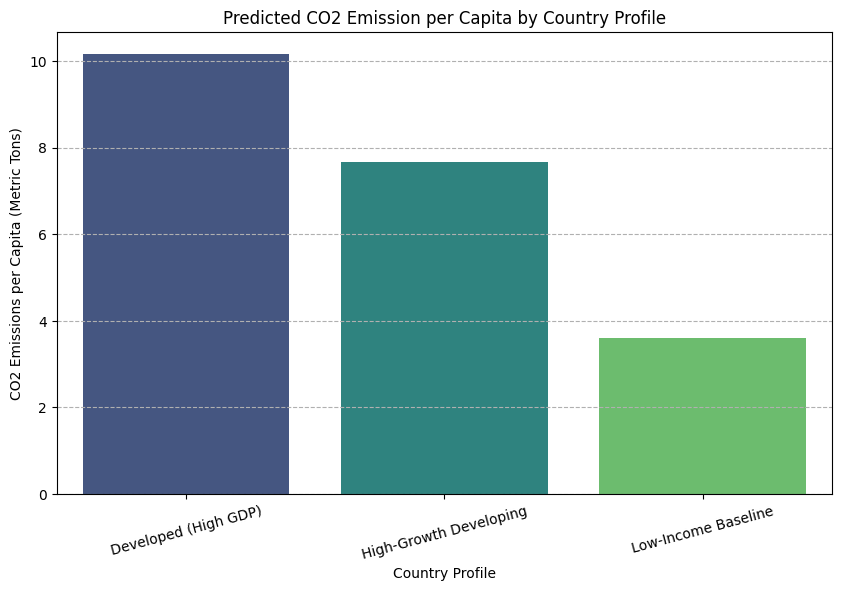


--- Final Prediction Summary ---
               Profile  Predicted CO2
  Developed (High GDP)         10.162
High-Growth Developing          7.671
   Low-Income Baseline          3.599


In [264]:
# CO2 Emission Predictor (Visualization)
def predict_co2_emission(gdp_pc, energy_use_pc, region, model, feature_list, df_base):
    """Predicts CO2 emission for a given country profile."""
    
    # Define the raw indicator
    CO2_RAW_COL = 'EN.ATM.CO2E.PC'
    GDP_RAW_COL = 'NY.GDP.PCAP.CD'
    ENERGY_RAW_COL = 'EG.USE.PCAP.KG.OE'
    
    # Create a base DataFrame for prediction to handles region encoding
    pred_data = pd.DataFrame([[gdp_pc, energy_use_pc, region]], 
                             columns=[GDP_RAW_COL, ENERGY_RAW_COL, 'Region'])
    
    # One-Hot Encode the region, aligning with the training set columns
    pred_data = pd.get_dummies(pred_data, columns=['Region'], drop_first=True)
    
    # Ensure the prediction DataFrame has ALL the required OHE columns (fill missing with 0)
    for col in feature_list:
        if col not in pred_data.columns:
            pred_data[col] = 0
            
    # Select and reorder columns to match the trained model's feature order
    X_pred = pred_data[feature_list]
    
    # --- Output Check: Uncomment the line below to see the aligned input features ---
    print(f"\n[X_pred Input for {region}]")

    # Predict
    return model.predict(X_pred)[0] 


profiles = [
    {'gdp': 60000, 'energy': 6000, 'region': 'Europe & Central Asia', 'label': 'Developed (High GDP)'},
    {'gdp': 30000, 'energy': 4000, 'region': 'East Asia & Pacific', 'label': 'High-Growth Developing'},
    {'gdp': 5000, 'energy': 1000, 'region': 'South Asia', 'label': 'Low-Income Baseline'}
]

predictions = []
for p in profiles:
    co2 = predict_co2_emission(
        p['gdp'],
        p['energy'],
        p['region'],
        best_reg_model,          # Trained model (Random Forest Regressor)
        X_reg.columns.tolist(),  # Full feature list
        df_model                 # Base DataFrame for alignment
    )
    predictions.append({'Profile': p['label'], 'Predicted CO2': co2})

df_pred = pd.DataFrame(predictions)

## Predicted CO2 Emissions Visualization

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_pred, 
    x='Profile', 
    y='Predicted CO2', 
    palette='viridis'
)
plt.title('Predicted CO2 Emission per Capita by Country Profile')
plt.ylabel('CO2 Emissions per Capita (Metric Tons)')
plt.xlabel('Country Profile')
plt.grid(axis='y', linestyle='--')
plt.xticks(rotation=15)
plt.show() # Display the bar chart

## Prediction Summary Output

print("\n--- Final Prediction Summary ---")
print(df_pred.to_string(index=False))